# 0. Setting Up The Env

In [27]:
from pathlib import Path

In [28]:
import pandas as pd 
import numpy as np

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")


In [30]:
project_root = Path.cwd().parent
project_root

WindowsPath('d:/01 Work/06-Segmentations')

In [31]:
file_path = f"{project_root}/data/raw/bank.csv"
file_path

'd:\\01 Work\\06-Segmentations/data/raw/bank.csv'

# 1. The Data

In [32]:
data_df  = pd.read_csv(file_path, sep=";")
print(f"The data has {data_df.shape[0]} rows and {data_df.shape[1]} columns")
print("Data Preview:")
data_df.head()

The data has 4521 rows and 17 columns
Data Preview:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


# 2. Data Check

In [33]:
print(data_df.isnull().sum())




age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [34]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


## 2.1 Target Var

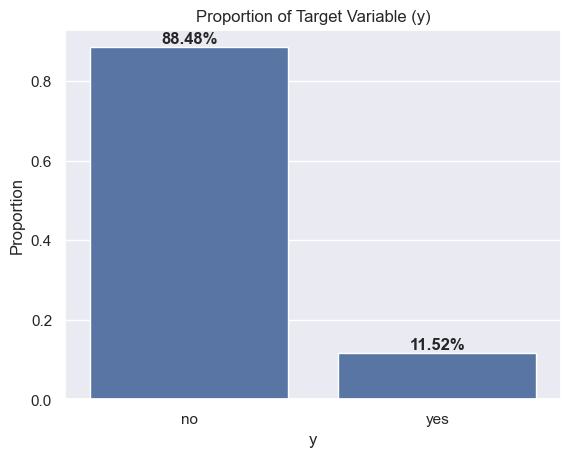

In [39]:
ax = sns.barplot(
    x=data_df['y'].value_counts(normalize=True).index,
    y=data_df['y'].value_counts(normalize=True).values,
)

# Add percentage labels
for i, v in enumerate(data_df['y'].value_counts(normalize=True).values):
    ax.text(i, v + 0.01, f"{v:.2%}", ha="center", fontweight="bold")

ax.set_title("Proportion of Target Variable (y)")
ax.set_xlabel("y")
ax.set_ylabel("Proportion")
plt.show()

## 2.2 Numeric Columns

In [40]:
data_df.describe().T


,count,mean,std,min,25%,50%,75%,max
age,4521.0,41.170095,10.576211,19.0,33.0,39.0,49.0,87.0
balance,4521.0,1422.657819,3009.638142,-3313.0,69.0,444.0,1480.0,71188.0
day,4521.0,15.915284,8.247667,1.0,9.0,16.0,21.0,31.0
duration,4521.0,263.961292,259.856633,4.0,104.0,185.0,329.0,3025.0
campaign,4521.0,2.793630,3.109807,1.0,1.0,2.0,3.0,50.0
pdays,4521.0,39.766645,100.121124,-1.0,-1.0,-1.0,-1.0,871.0
previous,4521.0,0.542579,1.693562,0.0,0.0,0.0,0.0,25.0


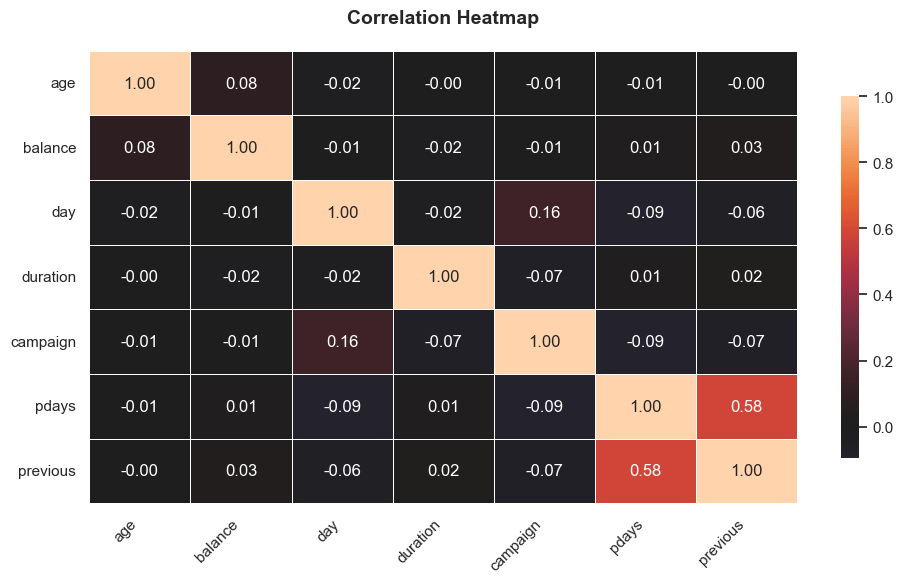

In [43]:
plt.figure(figsize=(10, 6))
corr = data_df.corr(numeric_only=True)

ax = sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",              # format correlations
    center=0,               # center at 0 for diverging colormap
    linewidths=0.5,         # add grid lines
    cbar_kws={"shrink": .8} # shrink colorbar for readability
)

ax.set_title("Correlation Heatmap", fontsize=14, fontweight="bold", pad=20)
plt.xticks(rotation=45, ha="right")   # rotate x labels
plt.yticks(rotation=0)                # keep y labels horizontal
plt.tight_layout()
plt.show()

No strong correlations between anything, other than **pdays**(*number of days that passed by after the client was last contacted from a previous campaign*) and **previous**(*number of contacts performed before this campaign and for this client*) which shows medium correlationship

## 2.3 Categorical Columns

In [48]:
data_df.describe(include=['O']).T

,count,unique,top,freq
job,4521,12,management,969
marital,4521,3,married,2797
education,4521,4,secondary,2306
default,4521,2,no,4445
housing,4521,2,yes,2559
loan,4521,2,no,3830
contact,4521,3,cellular,2896
month,4521,12,may,1398
poutcome,4521,4,unknown,3705
y,4521,2,no,4000


In [53]:
for col in data_df.select_dtypes(include="object"):
    print( data_df[col].value_counts(normalize=True))
    print("*"*100)

job
management       0.214333
blue-collar      0.209246
technician       0.169874
admin.           0.105729
services         0.092236
retired          0.050874
self-employed    0.040478
entrepreneur     0.037160
unemployed       0.028312
housemaid        0.024773
student          0.018580
unknown          0.008405
Name: proportion, dtype: float64
****************************************************************************************************
marital
married     0.618668
single      0.264543
divorced    0.116788
Name: proportion, dtype: float64
****************************************************************************************************
education
secondary    0.510064
tertiary     0.298607
primary      0.149967
unknown      0.041363
Name: proportion, dtype: float64
****************************************************************************************************
default
no     0.98319
yes    0.01681
Name: proportion, dtype: float64
******************************************

* **Month** Can be converted to periodic for numeric calculations
* *Binary Columns* can also be converted for easier calculations

In [54]:
pd.crosstab(data_df['job'], data_df['y'], normalize='index')


y,no,yes
job,,
admin.,0.878661,0.121339
blue-collar,0.927061,0.072939
entrepreneur,0.910714,0.089286
housemaid,0.875000,0.125000
management,0.864809,0.135191
retired,0.765217,0.234783
self-employed,0.890710,0.109290
services,0.908873,0.091127
student,0.773810,0.226190


In [56]:
data_df['age_group'] = pd.cut(data_df['age'], bins=[18,30,40,50,60,100])
pd.crosstab(data_df['age_group'], data_df['y'], normalize='index')


y,no,yes
age_group,,
"(18, 30]",0.857595,0.142405
"(30, 40]",0.901111,0.098889
"(40, 50]",0.894148,0.105852
"(50, 60]",0.897500,0.102500
"(60, 100]",0.622047,0.377953


# END